For $N_i$ fixed ions of charge $+Ze$ and $N_e$ electrons of charge $-e$ travelling in random directions at speed $v$, accelerating electrons emit isotropically.
$$\frac{\epsilon_{\nu}}{4\pi} = \frac{8 Z^2 e^6}{3m^2 v c^3}N_i N_e \frac{\pi}{\sqrt{3}}g_{ff}$$

Since unbound, use an analogous quantum number $\eta$ such that the initial state $E_i = Z^2 I_0 / \eta^2$ and the final energy state is $E_f = Z^2 I_0 / \eta'^2$, for $I_0 = m e^4 / (2\hbar)^2$. With manipulation, $\eta = Z \alpha / \beta$ and $\eta' = Z \alpha / \sqrt{\beta + 2 \alpha^2 E_f}$ with corresponding wavenumbers.

Quantum Woo $\rightarrow$ analytical continuation garbage that doesn't really matter understand $g_{ff}$, which is a ratio of the QM cross-section and the semi-classical derived cross-section.

$$g_{ff} =\frac{2\sqrt{3}}{\pi \eta_i \eta_f}[(\eta_i^2 + \eta_f^2 + 2\eta_i^2\eta_f^2)I_0 - 2\eta_i\eta_f(1+\eta_i^2)^{1/2}(1+\eta_f^2)^{1/2}I_1]I_0$$
Where $I_l$ has some functional form.

In [63]:
import numpy as np
from scipy import constants
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
from mpmath import hyp2f1, factorial, gamma
fsc = constants.alpha      

In [64]:
def I(eta_i, eta_f, k_i, k_f, l):
    """something dumb
    
    Arguments:
    eta_i  : modified quantum number associated with initial energy
    eta_f  : modified quantum number associated with final energy
    k_i    : wavenumber associated with initial energy
    k_f    : wavenumber associated with final energy
    l      : azimuthal quantum number
    
    Returns:
    I_l    : some number.
    """
    temp1 = 1/4*(4.* k_i * k_f / (k_i - k_f)**2)**(l+1) 
    temp2 = np.exp(np.pi/2*abs(eta_i - eta_f))
    temp3 = abs(gamma(l+1+1j*eta_i) * gamma(l+1+1j*eta_f)) / gamma(2.*l + 2)
    return temp1 * temp2 * temp3 * G(eta_i, eta_f, k_i, k_f, l)

def G(eta_i, eta_f, k_i, k_f, l):
    """something dumb helper"""
    if abs(-4.*k_i*k_f/(k_i-k_f)**2) > 1:
        temp1 = abs((k_f - k_i) / (k_f + k_i))**(1j*eta_i + 1j*eta_f) * gamma(2*l + 2)
        
        temp2 = gamma(1j * eta_f - 1j * eta_i) / gamma(l + 1 - 1j * eta_i) / gamma(l + 1 + 1j*eta_f)
        temp2 *= (4.*k_i*k_f/(k_f-k_i)**2)**(-l-1+1j*eta_f)
        temp2 *= hyp2f1(l+1-1j*eta_f, 
                        -l-1j*eta_f, 
                        1 + 1j*eta_i - 1j * eta_f, 
                        -(k_f-k_i)**2 / (4.*k_i*k_f))
        
        temp3 = gamma(1j * eta_i - 1j * eta_f) / gamma(l + 1 + 1j * eta_i) / gamma(l + 1 - 1j*eta_f)
        temp3 *= (4.*k_i*k_f/(k_f-k_i)**2)**(-l-1+1j*eta_i)
        temp3 *= hyp2f1(l+1-1j*eta_i, 
                        -l-1j*eta_i, 
                        1 + 1j*eta_f - 1j * eta_i, 
                        -(k_f-k_i)**2 / (4.*k_i*k_f))
        
        return (temp1 * (temp2 + temp3)).real
    
    else:
        temp1 = abs((k_f - k_i) / (k_f + k_i))**(1j*eta_i + 1j*eta_f)
        temp2 = hyp2f1(l+1-1j*eta_f, 
                       l+1-1j*eta_i, 
                       2.*l+2, 
                       -4.*k_i*k_f/(k_i-k_f)**2)

        return (temp1 * temp2).real

In [65]:
def gaunt_free_free(Z, beta, E):
    """calculate the Gaunt factor for free-free emission
    
    Arguments:
    Z    : ion charge, int
    beta : velocity of incident electron in units of c, float or array
    E    : energy of photon in units of Ha, float or array
    
    Returns:
    g_ff : gaunt factor for free-free emission"""
    
    eta_i = Z * fsc / beta
    k_i = beta / fsc
    eta_f = Z * fsc / (beta**2 + 2*E*fsc**2)**.5
    k_f = Z / eta_f
    if k_i == k_f:
        return 0
    I0 = I(eta_i, eta_f, k_i, k_f, 0)
    I1 = I(eta_i, eta_f, k_i, k_f, 1)
    
    out = 2*3**.5/np.pi/eta_i/eta_f * I0
    out *=((eta_i**2 + eta_f**2 + 2*eta_i**2*eta_f**2)*I0 - 2 * eta_i * eta_f * (1 + eta_i**2)**.5*(1+eta_f**2)**.5*I1)
    return out.real

In [66]:
def free_free_emission_spectrum(Z, hnu, E):
    """calculate free-free spectrum / sr
    
    Arguments:
    Z    : ion charge, int
    hnu  : energy of emitted photon, in Ha
    E    : electron final energy, in Ha"""
    if hnu >= E:
        return 0.
    g_ff = gaunt_free_free(Z, fsc * (2*(E - hnu))**.5, hnu)
    return 64 * np.pi**2 / 3 / 3**.5 * Z**2 * fsc**3 / (2*E)**.5 * g_ff

The free-free emission per unit volume of a thermal gas is obtained averaging over a Maxwellian distribution, $f(E) \propto \sqrt{E} exp(-E/T)$

In [67]:
def free_free_thermal_spectrum(Z, T, E):
    """calculate free-free spectrum / sr 
    from an ensemble of electrons following a Maxwellian
    
    Arguments:
    Z    : ion charge, int
    T    : temperature of electrons, in Ha
    E    : energies of emitted photons, in Ha
    """
    out = np.zeros_like(E)
    for i, hnu in enumerate(E):
        out[i] = scipy.integrate.quad(lambda x: x**.5 * np.exp(-x / T) * free_free_emission_spectrum(Z, hnu, x), hnu, np.inf)[0]
        out[i] /= scipy.integrate.quad(lambda x: x**.5 * np.exp(-x / T), 0, np.inf)[0]
    return out

Emissivity $j_{\nu}$ of free-free emission from an ensemble of electrons therefore is proportional to the temperature weighted Gaunt factor.
$$j_{\nu,ff} = \frac{1}{4\pi} \frac{8 Z^2 e^6}{3m^2 c^3}N_i N_e \bigg(\frac{2 \pi m}{3 k T}\bigg)^{1/2} \int_{h\nu}^{\infty}g(E, \nu) e^{-E / k T} d\frac{E}{k T}$$

In [68]:
def bar_gaunt_free_free(Z, T, hnu):
    """temperature weighted Gaunt factor
    
    Arguments:
    Z    : ion charge, int
    T    : temperature of electrons, in Ha
    hnu  : energy of emitted photon, in Ha"""
    out = scipy.integrate.quad(lambda x: np.exp(-x/T) * gaunt_free_free(Z, fsc*(2*(x-hnu))**.5, hnu), hnu, np.inf)[0]
    return out / T

I am putting emissivity in cgs units.

In [69]:
def emissivity_free_free(Z, Ni, Ne, T, nu):
    """calculate emissivity of free free emission
    
    Arguments:
    Z    : ion charge, int
    Ni   : ion density, in cm^-3
    Ne   : electron density, in cm^-3
    T    : temperature of electrons, in K
    nu   : frequency, in Hz
    """
    T_Ha = T * 3.16680853419133e-6
    hnu_Ha = nu * 1.519828500715e-16

    c = constants.c * 1.e2 # in cm/s
    e_e = 4.80320451e-10 #in statcoulomb
    m_e = constants.electron_mass * 1e3 # in g
    k = 1.380648780669e-16
    
    bgff = bar_gaunt_free_free(Z, T_Ha, hnu_Ha)
    
    prefactor = 1/4/np.pi * 8 * Z**2 * e_e**6 / 3 / m_e**2 / c**3
    temp2 = (2 * np.pi * m_e / 3 /k/T)**.5
    
    return Ni*Ne*prefactor*temp2*bgff

In [71]:
emissivity_free_free(1, 1, 1, 1000, 1e11)

2.691690061467795e-41

In [43]:
Z = 1.0
energies = np.logspace(-5,8,101) # Ry
velocities = np.sqrt(energies*fsc**2) # Ha
photon_energies = np.logspace(-6,8, 15) # Ry

gff1 = [[gaunt_free_free(Z, v, photon_energy/2.) for v in velocities] for photon_energy in photon_energies]


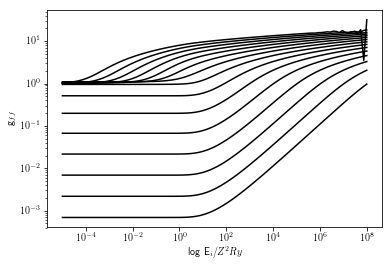

In [44]:
[plt.loglog(energies, gff1[i],'k') for i in range(len(photon_energies))]
plt.xlabel(r'log E_i/Z^2 Ry')
plt.ylabel(r'g_{ff}')

In [45]:
Z = 1.0
energies = np.logspace(-5,8,14) # Ry
velocities = np.sqrt(energies*fsc**2) # Ha
photon_energies = np.logspace(-6,8, 101) # Ry

gff2 = [[gaunt_free_free(Z, v, photon_energy/2.) for photon_energy in photon_energies] for v in velocities]

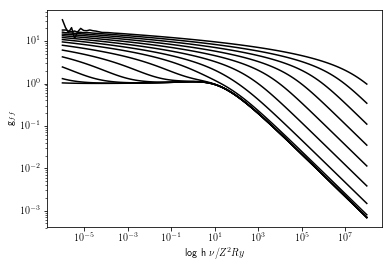

In [46]:
[plt.loglog(photon_energies, gff2[i],'k') for i in range(len(velocities))]
plt.xlabel(r'log h \nu / Z^2 Ry')
plt.ylabel(r'g_{ff}')

In [32]:
l_nm = np.logspace(-4,2,100)

# Determine energy range.
energies_eV = 1239.8/l_nm
energies_Ha = energies_eV/27.2

Ha_to_eV = 27.2
T = np.logspace(1,5,5)
spectra_eV = [free_free_thermal_spectrum(1.0, t/Ha_to_eV, energies_Ha) for t in T]

### Convert to wavelength spectrum.
spectra_nm = [spectrum_eV / l_nm**2 for spectrum_eV in spectra_eV]
outdata = spectra_nm


/Users/Briesemeister/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


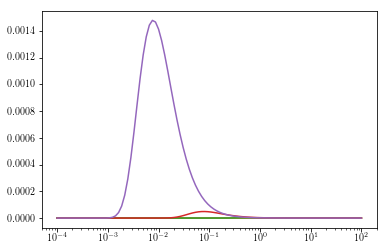

In [33]:
[plt.semilogx(l_nm,spectra_nm[i] ) for i in range(len(spectra_nm))];

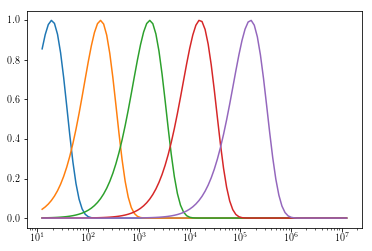

In [34]:
[plt.semilogx(energies_eV,spectra_nm[i]/spectra_nm[i].max() ) for i in range(len(spectra_nm))];

In [41]:
import numpy as np
l_nm1 = np.logspace(-4,2,100)

# Determine energy range.
energies_eV1 = 1239.8/l_nm1
energies_Ha1 = energies_eV1/27.2

Ha_to_eV1 = 27.2
T1 = [4e5]#np.linspace(10,50,41)
spectra_eV1 = [free_free_thermal_spectrum(1.0, t/Ha_to_eV1, energies_Ha1) for t in T1]

### Convert to wavelength spectrum.
spectra_nm1 = [spectrum_eV / l_nm1**2 for spectrum_eV in spectra_eV1]
outdata1 = spectra_nm1


/Users/Briesemeister/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


[[<matplotlib.lines.Line2D at 0x11ca5a080>]]

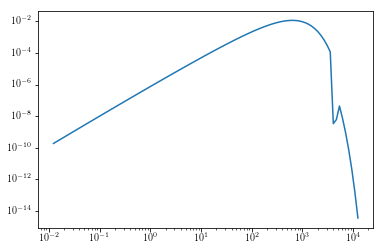

In [42]:
[plt.loglog(energies_eV1/1000,spectra_nm1[i]) for i in range(len(spectra_nm1))]